In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torchvision.models import resnet50
from torchvision.transforms import Compose, ToTensor, Resize

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm

from PIL import Image

import timm

import os
import random

In [8]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU

In [9]:
train_path = os.path.join("..", "input", "data", "train")
eval_path = os.path.join("..", "input", "data", "eval")

In [10]:
df_train = pd.read_csv(os.path.join(train_path, "train.csv"))
df_eval = pd.read_csv(os.path.join(eval_path, "info.csv"))

In [11]:
class MaskDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        all_images = []
        for path in df_train["path"]:
            image_path = os.path.join(train_path, "images", path)
            all_images += [os.path.join(image_path, image_filename) for image_filename in os.listdir(image_path) if image_filename[0] != "."]

        self.categories = {stat: i for i, stat in enumerate((Mask+Gender+Age) for Mask in ["Wear", "Incorrect", "NotWear"] for Gender in ["male", "female"] for Age in ["Under30", "30to60", "Overeq60"])}
        self.transform = transform

        category = []
        class_masked = []
        class_sex = []
        class_age = []
        for image_filename in all_images:
            *_, person_info, mask_info = image_filename.split(os.sep)
            id, sex, _, age = person_info.split('_')
            age = int(age)
            if mask_info[:-4] == "normal":
                mask_info = "NotWear"
            elif mask_info[:-4] == "incorrect_mask":
                mask_info = "Incorrect"
            else:
                mask_info = "Wear"
            
            if age < 30:
                age = "Under30"
            elif age >= 60:
                age = "Overeq60"
            else:
                age = "30to60"
                
            category.append(self.categories[mask_info+sex+age])
            
            class_masked.append(mask_info)
            class_sex.append(sex)
            class_age.append(age)
            
        self.train_Xy = pd.DataFrame(data=[all_images, category, class_masked, class_sex, class_age]).transpose()
        # self.train_Xy.columns = ["image_path", "class", "masked", "sex", "age"]
        self.train_Xy = self.train_Xy.to_numpy()
        
    def __getitem__(self, idx):
        image = Image.open(self.train_Xy[idx][0])
        if self.transform:
            image = self.transform(image)
        label = self.train_Xy[idx][1]
        return image, label

    def __len__(self):
        return len(self.train_Xy)

In [12]:
class MaskDatasetEval(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.df_eval = pd.read_csv(os.path.join(eval_path, "info.csv"))
        self.eval_image_path = os.path.join(eval_path, "images")
        self.transform = transform
        
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.eval_image_path, self.df_eval['ImageID'][idx]))
        if self.transform:
            image = self.transform(image)
        return image, self.df_eval['ImageID'][idx]

    def __len__(self):
        return len(self.df_eval)

In [13]:
ds = MaskDataset(transform=Compose([ToTensor()]))
ds_eval = MaskDatasetEval(transform=Compose([ToTensor()]))

In [14]:
# train_ds, test_ds = train_test_split(ds, test_size=0.2, stratify=list(range(18)))
train_ds, valid_ds = random_split(ds, [int(len(ds)*0.8), int(len(ds)*0.2)])

In [15]:
train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, drop_last=True)
valid_dataloader = DataLoader(valid_ds, batch_size=32, shuffle=True, num_workers=4, drop_last=True)

In [16]:
# model = resnet50(pretrained=True)
# model.fc = nn.Linear(in_features=2048, out_features=18)

model = timm.create_model('efficientnet_b0', pretrained=True)
model.classifier = nn.Linear(1280, 18)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

epoch = 50
epoch_start=1
patience = 5
best_loss = np.inf
counter = 0
start_from_checkpoint=False

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

train_loss_list = []
val_loss_list = []
val_metric_list = []

"""
"epoch": i,
"model_state_dict": model.state_dict(),
"optimizer_state_dict": optimizer.state_dict(),
"earlystop_bestloss": best_loss,
"earlystop_counter": counter,
"train_losslist": train_loss_list,
"val_losslist": val_loss_list,
"val_metrics": val_metric_list
"""
if start_from_checkpoint:
    checkpoint_name = "checkpoint/epoch13_met0.9933840502285781"
    checkpoint = torch.load(checkpoint_name)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch_start = checkpoint["epoch"] + 1
    best_loss = checkpoint["earlystop_bestloss"]
    counter = checkpoint["earlystop_counter"]
    train_loss_list = checkpoint["train_losslist"]
    val_loss_list = checkpoint["val_losslist"]
    val_metric_list = checkpoint["val_metrics"]

for i in range(epoch_start, epoch):
    print("---------------------------------------")
    print(f"epoch {i}")
    model.train()
    acc = 0
    total_loss = 0
    pred_list = None
    y_list = None
    for X, y in tqdm(train_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred_onehot = pred.argmax(dim=1)
        acc += sum(pred_onehot == y) / X.shape[0]
        total_loss += loss.item()
        
        if pred_list is not None:
            pred_list = torch.cat((pred_list, pred_onehot))
            y_list = torch.cat((y_list, y))
        else:
            pred_list = pred_onehot
            y_list = y
    print(f"train loss : {total_loss/len(train_dataloader)}, acc : {acc/len(train_dataloader) * 100}%", end=" ")
    print("f1 score : ", f1_score(y_list.cpu(), pred_list.cpu(), labels=list(range(18)), average='weighted'))
    train_loss_list.append(total_loss/len(train_dataloader))
    
    model.eval()
    acc = 0
    total_loss = 0
    pred_list = None
    y_list = None
    with torch.no_grad():
        for X, y in tqdm(valid_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            pred_onehot = pred.argmax(dim=1)
            loss = loss_fn(pred, y).item()
            acc += sum(pred_onehot == y) / X.shape[0]
            total_loss += loss
            
            if pred_list is not None:
                pred_list = torch.cat((pred_list, pred_onehot))
                y_list = torch.cat((y_list, y))
            else:
                pred_list = pred_onehot
                y_list = y
    total_loss = total_loss/len(valid_dataloader)
    val_f1 = f1_score(y_list.cpu(), pred_list.cpu(), labels=list(range(18)), average='weighted')
    print(f"val loss : {total_loss}, acc : {acc/len(valid_dataloader) * 100}%, f1 score : {val_f1}")
    val_loss_list.append(val_f1)
    val_metric_list.append(val_f1)
    
    torch.save({
        "epoch": i,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "earlystop_bestloss": best_loss,
        "earlystop_counter": counter,
        "train_losslist": train_loss_list,
        "val_losslist": val_loss_list,
        "val_metrics": val_metric_list
    }, os.path.join("checkpoint", f"epoch{i}_met{val_metric_list[-1]}"))
    
    if best_loss > total_loss:
        print(f"validation loss improved. {best_loss}->{total_loss}")
        best_loss = total_loss
        counter = 0
        torch.save(model.state_dict(), os.path.join("checkpoint", "best.pt"))
    else:
        counter += 1
    if counter == patience:
        print(f"No validation improvement until {patience} iteration. Stopping.")
        break
    
    print("")
    
best_checkpoint = torch.load("checkpoint/best.pt")
model.load_state_dict(best_checkpoint)

---------------------------------------
epoch 1



train loss : 1.4609424796397403, acc : 65.00264739990234% f1 score :  0.611411852043587



val loss : 0.6336902165311878, acc : 83.36864471435547%, f1 score : 0.7993579627736883
validation loss improved. inf->0.6336902165311878

---------------------------------------
epoch 2



train loss : 0.517244085606377, acc : 85.74549865722656% f1 score :  0.8358402091739796



val loss : 0.3471731967845206, acc : 90.121826171875%, f1 score : 0.8844087677482998
validation loss improved. 0.6336902165311878->0.3471731967845206

---------------------------------------
epoch 3



train loss : 0.32295417921396635, acc : 90.48596954345703% f1 score :  0.892941128106857



val loss : 0.2521660163746042, acc : 92.05508422851562%, f1 score : 0.9111179607819555
validation loss improved. 0.3471731967845206->0.2521660163746042

---------------------------------------
epoch 4



train loss : 0.23040108546077953, acc : 92.98860931396484% f1 score :  0.9229290884177115



val loss : 0.18471775630141718, acc : 93.75%, f1 score : 0.9322306623399284
validation loss improved. 0.2521660163746042->0.18471775630141718

---------------------------------------
epoch 5



train loss : 0.16190287792044927, acc : 95.09400939941406% f1 score :  0.9474986269269697



val loss : 0.1429962011022588, acc : 95.28601837158203%, f1 score : 0.9503501608215204
validation loss improved. 0.18471775630141718->0.1429962011022588

---------------------------------------
epoch 6



train loss : 0.11334041487504491, acc : 96.88162231445312% f1 score :  0.9676215873276218



val loss : 0.10296825821495663, acc : 97.08686828613281%, f1 score : 0.9701394401285023
validation loss improved. 0.1429962011022588->0.10296825821495663

---------------------------------------
epoch 7



train loss : 0.07714750561508019, acc : 98.14618682861328% f1 score :  0.9811649797604748



val loss : 0.08416408488242808, acc : 97.72245788574219%, f1 score : 0.9773215474354073
validation loss improved. 0.10296825821495663->0.08416408488242808

---------------------------------------
epoch 8



train loss : 0.054844253199269714, acc : 98.81488037109375% f1 score :  0.9880932461403333



val loss : 0.062126179525660255, acc : 98.17266845703125%, f1 score : 0.9816403354559246
validation loss improved. 0.08416408488242808->0.062126179525660255

---------------------------------------
epoch 9



train loss : 0.040154977773624013, acc : 99.22537231445312% f1 score :  0.9922462182588428



val loss : 0.05303986182720479, acc : 98.49046325683594%, f1 score : 0.9847863012357942
validation loss improved. 0.062126179525660255->0.05303986182720479

---------------------------------------
epoch 10



train loss : 0.02876117890868415, acc : 99.496826171875% f1 score :  0.9949670506490369



val loss : 0.049089367779650554, acc : 98.62287902832031%, f1 score : 0.9858308399328906
validation loss improved. 0.05303986182720479->0.049089367779650554

---------------------------------------
epoch 11



train loss : 0.02291410941713474, acc : 99.61599731445312% f1 score :  0.9961585090358868



val loss : 0.04280754006309909, acc : 98.67584991455078%, f1 score : 0.9866660840335866
validation loss improved. 0.049089367779650554->0.04280754006309909

---------------------------------------
epoch 12



train loss : 0.017724879770204267, acc : 99.66896057128906% f1 score :  0.9966907058875049



val loss : 0.041055948399520335, acc : 98.75529479980469%, f1 score : 0.9872725770168054
validation loss improved. 0.04280754006309909->0.041055948399520335

---------------------------------------
epoch 13



train loss : 0.013931927903579012, acc : 99.7550277709961% f1 score :  0.9975499437826891



val loss : 0.039770002154262456, acc : 98.70233154296875%, f1 score : 0.9869258058191693
validation loss improved. 0.041055948399520335->0.039770002154262456

---------------------------------------
epoch 14



train loss : 0.012142861588025402, acc : 99.76165008544922% f1 score :  0.9976160745376808



val loss : 0.035896479273491176, acc : 98.99364471435547%, f1 score : 0.9899516062630729
validation loss improved. 0.039770002154262456->0.035896479273491176

---------------------------------------
epoch 15



train loss : 0.011753103891027484, acc : 99.79475402832031% f1 score :  0.9979460069311554



val loss : 0.03301388322586841, acc : 98.96715545654297%, f1 score : 0.9895938884362426
validation loss improved. 0.035896479273491176->0.03301388322586841

---------------------------------------
epoch 16



train loss : 0.00902182058028194, acc : 99.84772491455078% f1 score :  0.9984769394043479



val loss : 0.03370451672995163, acc : 99.12606048583984%, f1 score : 0.9913025575424942

---------------------------------------
epoch 17



train loss : 0.0069530043013909856, acc : 99.88082885742188% f1 score :  0.998808308467518



val loss : 0.035865538631727666, acc : 99.02012634277344%, f1 score : 0.9901403082267971

---------------------------------------
epoch 18



train loss : 0.006540923111199429, acc : 99.887451171875% f1 score :  0.9988744883415948



val loss : 0.03293897428658842, acc : 99.12606048583984%, f1 score : 0.9913580134710992
validation loss improved. 0.03301388322586841->0.03293897428658842

---------------------------------------
epoch 19



train loss : 0.007202568080636842, acc : 99.84772491455078% f1 score :  0.9984770229655969



val loss : 0.028311423851168218, acc : 99.28495788574219%, f1 score : 0.992846796127282
validation loss improved. 0.03293897428658842->0.028311423851168218

---------------------------------------
epoch 20



train loss : 0.005558879462946838, acc : 99.89407348632812% f1 score :  0.9989404982681643



val loss : 0.027319909837264646, acc : 99.3644027709961%, f1 score : 0.9936335725252395
validation loss improved. 0.028311423851168218->0.027319909837264646

---------------------------------------
epoch 21



train loss : 0.00473704398067084, acc : 99.9205551147461% f1 score :  0.9992052586634119



val loss : 0.03378759193558727, acc : 99.12606048583984%, f1 score : 0.9912988423951762

---------------------------------------
epoch 22



train loss : 0.006149103243919622, acc : 99.84772491455078% f1 score :  0.9984761160213255



val loss : 0.028205403475282255, acc : 99.0730972290039%, f1 score : 0.9907540928240842

---------------------------------------
epoch 23



train loss : 0.0033268332915783612, acc : 99.94703674316406% f1 score :  0.9994703444267624



val loss : 0.025313372667955327, acc : 99.3644027709961%, f1 score : 0.9936744255760288
validation loss improved. 0.027319909837264646->0.025313372667955327

---------------------------------------
epoch 24



train loss : 0.0034067457042002095, acc : 99.94703674316406% f1 score :  0.9994703346153435



val loss : 0.027529607894147205, acc : 99.28495788574219%, f1 score : 0.9929075523756395

---------------------------------------
epoch 25



train loss : 0.0024297411687180335, acc : 99.98014068603516% f1 score :  0.9998015592425159



val loss : 0.02403895104103189, acc : 99.47034454345703%, f1 score : 0.9947058589492731
validation loss improved. 0.025313372667955327->0.02403895104103189

---------------------------------------
epoch 26



train loss : 0.0036718388217473227, acc : 99.90068817138672% f1 score :  0.9990071828446307



val loss : 0.027832510775192918, acc : 99.31143951416016%, f1 score : 0.9930703602534593

---------------------------------------
epoch 27



train loss : 0.0038834333563345816, acc : 99.9205551147461% f1 score :  0.9992054636550216



val loss : 0.024900176663369026, acc : 99.33792114257812%, f1 score : 0.9933859308748927

---------------------------------------
epoch 28



train loss : 0.0025036454070209014, acc : 99.95365905761719% f1 score :  0.9995363570285903



val loss : 0.02971128900352889, acc : 99.28495788574219%, f1 score : 0.9928566350255524

---------------------------------------
epoch 29



train loss : 0.0023924072345496024, acc : 99.94703674316406% f1 score :  0.9994697557619818



val loss : 0.0266928302407905, acc : 99.25847625732422%, f1 score : 0.9926085998808636

---------------------------------------
epoch 30



train loss : 0.004216720695278466, acc : 99.8543472290039% f1 score :  0.9985425151202406



val loss : 0.03713827545464683, acc : 99.04661560058594%, f1 score : 0.9904218513129529
No validation improvement until 5 iteration. Stopping.


<All keys matched successfully>

-----------------------------

## best model load, validation eval

In [30]:
model = resnet50(pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=18)

In [19]:
best_checkpoint = torch.load("checkpoint/best.pt")
model.load_state_dict(best_checkpoint)
model.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [20]:
loss = nn.CrossEntropyLoss()
model.eval()
acc = 0
total_loss = 0
pred_list = None
y_list = None
with torch.no_grad():
    for X, y in tqdm(valid_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        
        pred_onehot = pred.argmax(dim=1)
        loss = loss_fn(pred, y).item()
        acc += sum(pred_onehot == y) / X.shape[0]
        total_loss += loss
        
        if pred_list is not None:
            pred_list = torch.cat((pred_list, pred_onehot))
            y_list = torch.cat((y_list, y))
        else:
            pred_list = pred_onehot
            y_list = y
total_loss = total_loss/len(valid_dataloader)
val_f1 = f1_score(y_list.cpu(), pred_list.cpu(), labels=list(range(18)), average='weighted')
print(f"val loss : {total_loss}, acc : {acc/len(valid_dataloader) * 100}%, f1 score : {val_f1}")


val loss : 0.024039467038380544, acc : 99.47034454345703%, f1 score : 0.9947058520722094


----------------------------

## Submission만들기

In [ ]:
id_list = []
pred_list = []
model.eval()
with torch.no_grad():
    for img, id in tqdm(ds_eval):
        pred = model(img.unsqueeze(dim=0).cuda()).argmax(dim=1).item()
        id_list.append(id)
        pred_list.append(pred)

submission = pd.DataFrame(list(zip(id_list, pred_list)), columns = ["ImageID", "ans"])
submission.to_csv("submission.csv", index=False)

------------------

## validation wrong prediction 확인

In [21]:
target = []
prediction = []
with torch.no_grad():
    for X, y in tqdm(valid_dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        pred = pred.argmax(dim=1)
        indices = (pred != y).nonzero().squeeze()
        if indices.nelement() != 0:
            target.append(X[indices])
            prediction.append((pred[indices], y[indices]))

<ipython-input-21-35a40890541c>:9: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  indices = (pred != y).nonzero().squeeze()


In [22]:
len(target)

20

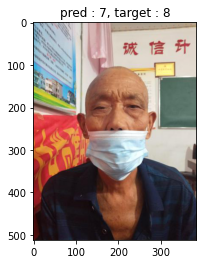

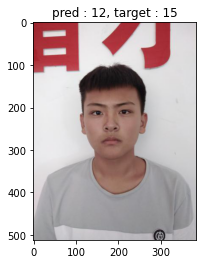

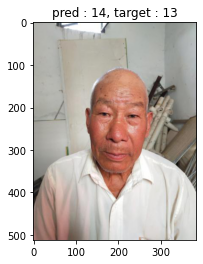

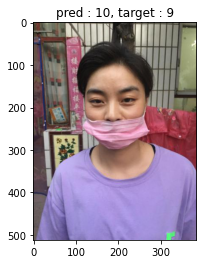

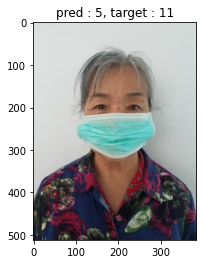

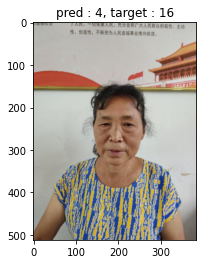

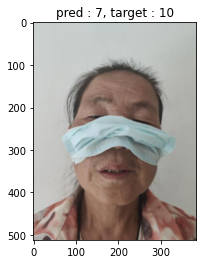

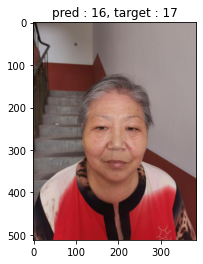

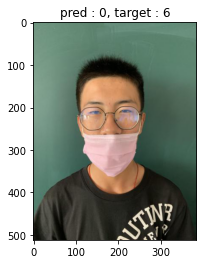

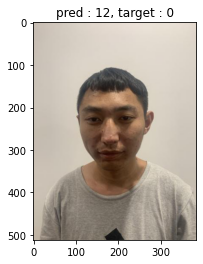

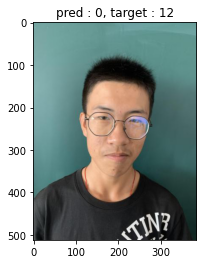

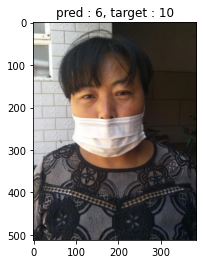

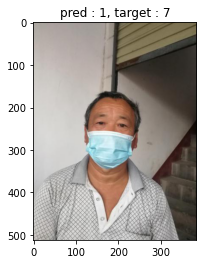

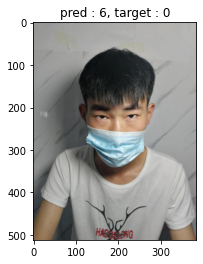

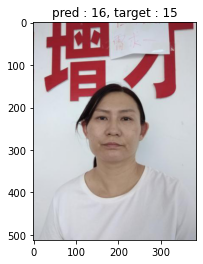

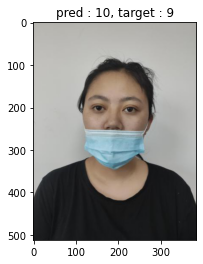

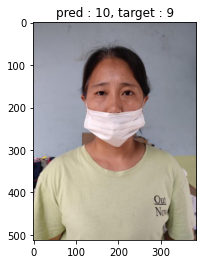

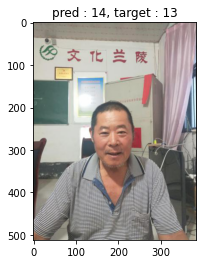

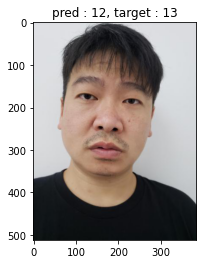

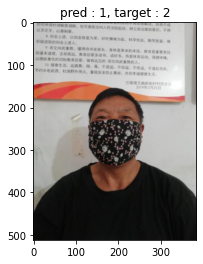

In [23]:
i = 1
for img, (pred, targ) in zip(target, prediction):
    if len(img.shape) == 4:
        for img_sep, p, t in zip(img, pred, targ):
            plt.title(f"pred : {p.item()}, target : {t.item()}")
            plt.imshow(img_sep.cpu().permute(1, 2, 0))
            plt.show()
    else:
        plt.title(f"pred : {pred.item()}, target : {targ.item()}")
        plt.imshow(img.cpu().permute(1, 2, 0))
        plt.show()
    i+=1